# Analyze the solution landscape of networks partitioned with Infomap
This notebook presents methods introduced in
<br>
**Exploring the solution landscape enables more reliable network community detection**
<br>
Joaquín Calatayud, Rubén Bernardo-Madrid, Magnus Neuman, Alexis Rojas, and Martin Rosvall.
<br>
[Phys. Rev. E 100, 052308 (2019)](https://doi.org/10.1103/PhysRevE.100.052308)
<br>
[arXiv:1905.11230](https://arxiv.org/abs/1905.11230) 
<br>
> To understand how a complex system is organized and functions, researchers often identify communities in the system's network of interactions. Because it is practically impossible to explore all solutions to guarantee the best one, many community-detection algorithms rely on multiple stochastic searches. But for a given combination of network and stochastic algorithm, how many searches are sufficient to find a solution that is good enough? The standard approach is to pick a reasonably large number of searches and select the network partition with the highest quality or derive a consensus solution based on all network partitions. However, if different partitions have similar qualities such that the solution landscape is degenerate, the single best partition may miss relevant information, and a consensus solution may blur complementary communities. Here we address this degeneracy problem with coarse-grained descriptions of the solution landscape. We cluster network partitions based on their similarity and suggest an approach to determine the minimum number of searches required to describe the solution landscape adequately. To make good use of all partitions, we also propose different ways to explore the solution landscape, including a significance clustering procedure. We test these approaches on synthetic and real-world networks, and find that different networks and algorithms require a different number of searches and that exploring the coarse-grained solution landscape can reveal noteworthy complementary solutions and enable more reliable community detection.

## Setup

In [1]:
# To install or upgrade to to the latest version of Infomap, see https://mapequation.github.io/infomap/
# pip install infomap / pip install --upgrade infomap
import sys
import infomap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import Image
from scipy.interpolate import griddata
import umap
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set(style="white")

#### Update to latest partition validation code (requires a gcc compiler)

In [2]:
%%bash
#Clone partition-validation repo if it does not exist, otherwhise pull. Then compile.
if [ ! -d "partition-validation" ] ; then
    git clone https://github.com/mapequation/partition-validation.git
else
    git -C partition-validation pull
fi
make -C partition-validation

Already up to date.
make: `partition-validation' is up to date.


#### Update infomap module

In [3]:
!pip install --upgrade infomap

Requirement already up-to-date: infomap in /Users/anton/.local/share/virtualenvs/solution-landscape-hwz0kbuk/lib/python3.7/site-packages (1.1.0)


#### Find communities in the network

In [4]:
def findCommunities(networkName="data/jazz.net", seed=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    im = infomap.Infomap(f"-s {seed}")
    im.read_file(networkName)
    
    print(f"Find communities in {networkName} with Infomap...")
    im.run()

    print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")
    communityDict = {node.node_id: ":".join(map(str, node.path[:-1]))
                    for node in im.nodes}
    
    return im.codelength, list(sorted(communityDict.values()))

In [5]:
def printCommunities(networkName="data/jazz.net", seed=1, outfile="outfile.tree"):
    """
    Partition network with the Infomap algorithm.
    Print partition to .tree file
    """

    im = infomap.Infomap(f"-s {seed}")
    im.read_file(networkName)
    
    print(f"Find communities in {networkName} with Infomap...")
    im.run()
    print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")
    
    print(f"Writing results to {outfile}")
    im.write_tree(outfile)
    return im.codelength

# Analyze partition robustness

#### Definitions

<dl>
  <dt>Distance threshold</dt>
  <dd>The maximum weighted Jaccard distance between a cluster center and any other partition in the same cluster.</dd>    
    
  <dt>Validation score</dt>
  <dd>The fraction of validation partitions that fit into existing clusters.</dd>

  <dt>Validation set size</dt>
  <dd>The number of partitions hold out when measuring the validation score.</dd>       
    
  <dt>Accuracy</dt>
  <dd>The threshold validation score for a complete solution landscape.</dd>
</dl>

#### Partition clustering algorithm

1. Order all p network partitions from highest to lowest quality (from shortest to longest code length).
2. Let the highest quality network partition form cluster center 1.
3. Repeat until all network partitions have been clustered. Among the not yet clustered partitions, pick the one with the highest quality and assign it to the first of the m cluster centers that it is closer to than the distance threshold. If no such cluster center exists, let it form cluster center m + 1.

#### Solution landscape completeness algorithm

To determine the sufficient number of searches for a solution that is good enough given the distance threshold and solution landscape accuracy, we 

1. Run Infomap twice the validation set size and add the new partitions to previously identified partitions.
2. Randomly split all partitions into a validation set and a training set. Run the partition clustering algorithm on the training set and measure the validation score on the validation set. Resample a specified number of times for better estimate.
3. Repeat 1. and 2. until the validation score is higher than the specified accuracy.

#### Guidelines

In general, a solution landscape with a small distance threshold and a high accuracy requires many partitions. Moreover, networks with a flat solution landscape, characterized by relatively small differences in code length for distant solutions, require more partitions than networks with a peaked solutions landscape, characterized by relatively large difference in code length for similar solutions. 

#### Networks

In [6]:
network = 'data/jazz.net' #  A network with a peaked solutions landscape, characterized by relatively large difference in code length for similar solutions.
accuracy = 0.9
distance_threshold = 0.02 # Requires 100 partitions

#network = 'data/email.net' # A network with a flat solution landscape, characterized by relatively small differences in code length for distant solutions.
#accuracy = 0.9
#distance_threshold = 0.3 # Requires 100 partitions
#distance_threshold = 0.25 # Requires > 2000 partitions

#### Find new solutions until complete solution landscape
Run as many searches as sufficient for a solution that is good enough given the distance threshold and solution landscape accuracy.

In [7]:
n_validation = 10
n_resamples = 100
currentValidationScore = 0.0
validation_data_df = pd.DataFrame(columns = ["n_validated","n_clusters","n_partitions","n_training","n_validation"])
partitions_df = pd.DataFrame()
niter = 5000

for i in range(niter):
    print(f"Iteration {i + 1}")
    codelength, communities = findCommunities(network, i)
    communities.insert(0, codelength)
    partitions_df = pd.concat([partitions_df, pd.DataFrame(communities, columns = [str(i)])], axis=1)
    
    if (i + 1) % (2 * n_validation) == 0:
        n_training = i + 1 - n_validation
        print(f"Running partition validation with {n_training} training partitions and {n_validation} validation partitions.")
        partitions_df.sort_values(by=0, axis=1, inplace=True)
        partitions_df.drop(0, axis=0, inplace=False).to_csv(r'results/partitions.csv', index=False, header=False, sep=' ')    
        !partition-validation/partition-validation -s 123 -t $distance_threshold --validation-sampling $n_training $n_validation $n_resamples results/partitions.csv results/partitions_clustering.txt
        validation_data_tmp_df = pd.read_csv('results/partitions_clustering_validation.txt', skiprows=1, header=None, delimiter=' ').rename(columns={0: "n_validated", 1: "n_clusters"})
        validation_data_tmp_df["n_partitions"] = i + 1
        validation_data_tmp_df["n_training"] = n_training
        validation_data_tmp_df["n_validation"] = n_validation
        currentValidationScore = validation_data_tmp_df['n_validated'].mean() / n_validation
        print(f"{100 * currentValidationScore}% of validation partitions fit in partition clusters from {n_training} training clusters.")
        validation_data_df = validation_data_df.append(validation_data_tmp_df, sort=False)
    if currentValidationScore > accuracy:
        break

Iteration 1
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.908787373822574
Iteration 2
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.868362109988096
Iteration 3
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861495959669509
Iteration 4
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.863719749729316
Iteration 5
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 6
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.908787373822574
Iteration 7
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.909756907430348
Iteration 8
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.864742285794233
Iteration 9
Find communities in data/jazz.net with Infomap...
Fo

62.1% of validation partitions fit in partition clusters from 10 training clusters.
Iteration 21
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 22
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 23
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 24
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 25
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Iteration 26
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Iteration 27
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 28
Find communities in data/jazz.net with Infomap...
Found 6 top modules with co

78.7% of validation partitions fit in partition clusters from 30 training clusters.
Iteration 41
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 42
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.866012550454389
Iteration 43
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Iteration 44
Find communities in data/jazz.net with Infomap...
Found 7 top modules with codelength: 6.865342792390932
Iteration 45
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.867850886784041
Iteration 46
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.86199334790942
Iteration 47
Find communities in data/jazz.net with Infomap...
Found 7 top modules with codelength: 6.865342792390932
Iteration 48
Find communities in data/jazz.net with Infomap...
Found 6 top modules with cod

77.9% of validation partitions fit in partition clusters from 50 training clusters.
Iteration 61
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 62
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.864742285794233
Iteration 63
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.908787373822574
Iteration 64
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.868362109988096
Iteration 65
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.868479896506625
Iteration 66
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.868362109988096
Iteration 67
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.8630672417271485
Iteration 68
Find communities in data/jazz.net with Infomap...
Found 5 top modules with c

81.1% of validation partitions fit in partition clusters from 70 training clusters.
Iteration 81
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.865010491756674
Iteration 82
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.909756907430348
Iteration 83
Find communities in data/jazz.net with Infomap...
Found 4 top modules with codelength: 6.869397317265148
Iteration 84
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.868362109988096
Iteration 85
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 86
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 87
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.865068218240896
Iteration 88
Find communities in data/jazz.net with Infomap...
Found 5 top modules with co

85.2% of validation partitions fit in partition clusters from 90 training clusters.
Iteration 101
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.863937940028137
Iteration 102
Find communities in data/jazz.net with Infomap...
Found 4 top modules with codelength: 6.8656404576349015
Iteration 103
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 104
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.909756907430348
Iteration 105
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.908787373822574
Iteration 106
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.862755928271476
Iteration 107
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.8630672417271485
Iteration 108
Find communities in data/jazz.net with Infomap...
Found 5 top modul

-->Number of validation partitions out of 10 that fits in one of 26 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.866667
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 23 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 55 samples: 0.86
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 27 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.8625
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 26 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 57 samples: 0.863158
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 25 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.862069
Clustering 110 partitions:
-->Nu

87.3% of validation partitions fit in partition clusters from 110 training clusters.
Iteration 121
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 122
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.8630672417271485
Iteration 123
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.8630672417271485
Iteration 124
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.864742285794233
Iteration 125
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 126
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.868479896506625
Iteration 127
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 128
Find communities in data/jazz.net with Infomap...
Found 5 top modu

89.39999999999999% of validation partitions fit in partition clusters from 130 training clusters.
Iteration 141
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.909756907430348
Iteration 142
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.862755928271476
Iteration 143
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 144
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.868362109988096
Iteration 145
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Iteration 146
Find communities in data/jazz.net with Infomap...
Found 7 top modules with codelength: 6.861951585760939
Iteration 147
Find communities in data/jazz.net with Infomap...
Found 4 top modules with codelength: 6.869397317265148
Iteration 148
Find communities in data/jazz.net with Infomap...
Found

88.9% of validation partitions fit in partition clusters from 150 training clusters.
Iteration 161
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 162
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 163
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.863047469426566
Iteration 164
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 165
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 166
Find communities in data/jazz.net with Infomap...
Found 5 top modules with codelength: 6.909779914575196
Iteration 167
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.909756907430348
Iteration 168
Find communities in data/jazz.net with Infomap...
Found 6 top module

92.89999999999999% of validation partitions fit in partition clusters from 170 training clusters.


#### Plot validation score for solution landscape completeness

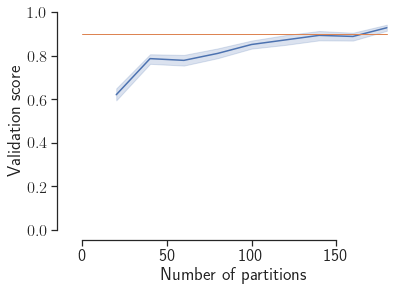

In [8]:
validation_data_df["score"] = (validation_data_df["n_validated"] / validation_data_df["n_validation"]).astype(float)
validation_data_df["n_partitions"] = validation_data_df["n_partitions"].astype(int)
sns.set(style="ticks", font_scale=1.5)
ax = sns.lineplot(x="n_partitions", y="score", markers=True, ci=95, data=validation_data_df)
ax.set(ylabel="Validation score", xlabel="Number of partitions", ylim=(0,1))
##plt.legend(loc=4)
plt.plot([0, validation_data_df["n_partitions"].max()], [accuracy, accuracy], '-', lw=1)
sns.despine(offset=10, trim=True);

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.savefig('results/ValidationScore.pdf')

**Figure 1** The validation score as a function of number of partitions with bootstrapped 95% confidence intervals and given accuracy level.

# Compare partitions

### Find partitions (not necessary if already done above)

In [9]:
generatePartitions = False

if generatePartitions:
    partitions_df = pd.DataFrame() 
    niter = 100
    for i in range(niter):
        print(f"Iteration {i+1}")
        codelength = findCommunities(G, i)
        communities = list(nx.get_node_attributes(G, 'community').values())
        communities.insert(0, codelength)
        partitions_df = pd.concat([partitions_df, pd.DataFrame(communities,columns = [str(i)])], axis=1)

### Identify partition clusters

In [10]:
partitions_df.sort_values(by=0, axis=1,inplace=True)
codelengths = partitions_df.loc[0,:].to_numpy()
partitions_df.drop(0, axis=0,inplace=False).to_csv(r'results/partitions.csv',index=False,header=False,sep=' ')
!partition-validation/partition-validation -s 123 -t $distance_threshold results/partitions.csv results/partitions_clustering.txt    

Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.02 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.02
-->Will read partitions from file: results/partitions.csv
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 180 partitions...of 198 nodes...done!
Clustering 180 partitions:
-->Writing 32 clusters...done!


### Read results and identify cluster sizes and cluster centers

#### Read partition clusters

In [11]:
# Only influde best maxclusters clusters
maxclusters = 20
partition_clusters_df = pd.read_csv('results/partitions_clustering.txt', delimiter=' ', comment='#')
Nclusters = partition_clusters_df['ClusterId'].max()
print(f"Solution landscape contains {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

if Nclusters > maxclusters:
    partition_clusters_df.drop(partition_clusters_df[partition_clusters_df.ClusterId > maxclusters].index, inplace=True)
    Nclusters = partition_clusters_df['ClusterId'].max()
    print(f"Including only the best {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

partition_clusters_df.head()

Solution landscape contains 32 clusters with 180 partitions.
Including only the best 20 clusters with 84 partitions.


,ClusterId,PartitionId
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


#### Cluster sizes

In [12]:
clusterSizes = partition_clusters_df['ClusterId'].value_counts(sort=False)
maxClusterSize = max(clusterSizes)
solution_landscape_df = clusterSizes.to_frame().rename(columns={'ClusterId':'clustersize'})

#### Cluster centers and code lengths

In [13]:
Nclusters = partition_clusters_df['ClusterId'].max()
clusterCenters = np.empty(Nclusters)

for clusterId in range(1, Nclusters + 1):
    clusterCenters[clusterId - 1] = partition_clusters_df['PartitionId'][(partition_clusters_df['ClusterId'] == clusterId).idxmax()]

clusterCenters = clusterCenters.astype(int)
clusterCenterCodelengths = codelengths[clusterCenters - 1]
solution_landscape_df['partitionid'] = clusterCenters.tolist()
solution_landscape_df['codelength'] = clusterCenterCodelengths.tolist()

#### Read pairwise cluster center distances

In [14]:
distances_df = pd.read_csv('results/partitions_clustering_distances.txt', delimiter=' ', comment='#')
distances_df.drop(distances_df[(distances_df['ClusterId1'] > maxclusters) | (distances_df['ClusterId2'] > maxclusters)].index, inplace=True)
distances_df.head()

,ClusterId1,ClusterId2,Distance
0,1,2,0.029304
1,1,3,0.066450
2,1,4,0.070605
3,1,5,0.274599
4,1,6,0.104787


#### Create partition distance matrix

Text(0.5, 1.0, 'Partition distance matrix')

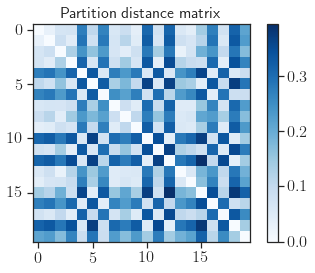

In [15]:
row = distances_df.to_numpy()[:,0].astype(int) - 1
col = distances_df.to_numpy()[:,1].astype(int) - 1
distances = distances_df.to_numpy()[:,2]
distance_matrix = np.zeros((Nclusters, Nclusters), dtype=distances.dtype)
distance_matrix[row, col] = distances
distance_matrix[col, row] = distances # Add transpose
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.title('Partition distance matrix', fontsize=16)

#### Identify coordinates in 2D with [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)

In [16]:
U = umap.UMAP(metric='precomputed', n_neighbors=Nclusters - 1, min_dist=distance_threshold)
out = U.fit_transform(distance_matrix)
solution_landscape_df['xcoord'] = out[:, 0]
solution_landscape_df['ycoord'] = out[:, 1]
solution_landscape_df.head()

,clustersize,partitionid,codelength,xcoord,ycoord
1,12,1,6.861230,-5.357516,-5.406085
2,2,8,6.861496,-5.251053,-5.859127
3,5,10,6.861952,-5.804302,-5.657763
4,3,11,6.861993,-5.151805,-6.956122
5,12,14,6.862756,-3.671646,-10.441666


#### Visualize solution landscape with contour plot

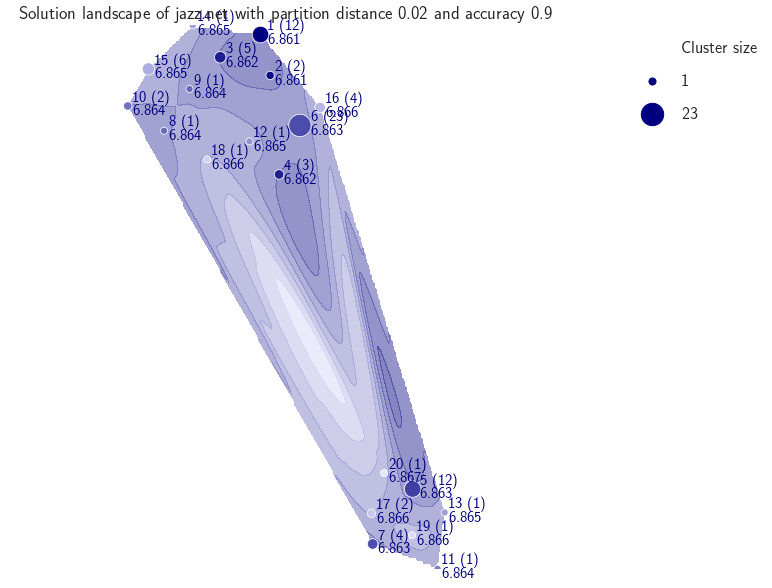

In [17]:
x = solution_landscape_df['xcoord'].values
y = solution_landscape_df['ycoord'].values
codelength = solution_landscape_df['codelength'].values

def plot_contour(x, y, codelength, resolution=200, contour_method='cubic'):
    resolution = f"{resolution}j"
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = list(zip(x, y))
    Z = griddata(points, codelength, (X, Y), method=contour_method)
    return X, Y, Z

X, Y, Z = plot_contour(x, y, codelength, resolution=200, contour_method='cubic')

palette = sns.light_palette("navy", reverse=True, as_cmap=True)
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
p0 = ax.contourf(X, Y, Z, cmap=palette, alpha=0.5)
#cbaxes = f.add_axes([0.8, 0.1, 0.03, 0.8])
#cbar = f.colorbar(p0, cax=cbaxes)
p1 = sns.scatterplot(x="xcoord", y="ycoord", hue="codelength", size="clustersize",
            sizes=(50, 500), alpha=1, palette=palette, legend="full",
            data=solution_landscape_df)
plt.axis('equal')
networkname = network.split("data/", 1)
networkname = networkname[len(networkname) - 1]
plt.title(f'Solution landscape of {networkname} with partition distance {distance_threshold} and accuracy {accuracy}')
plt.xlabel('')
#plt.xlabel('Embedded partition distance')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
handles, labels = ax.get_legend_handles_labels()
for handle in handles[Nclusters + 1:]:
    handle.set_color(palette(0))
labels[Nclusters + 1] = 'Cluster size'
#handlestepsize = max(int((len(handles)-(Nclusters+1))/4),1)
plt.legend([handles[Nclusters + 1], handles[Nclusters + 2], handles[-1]],
           [labels[Nclusters + 1], labels[Nclusters + 2], labels[-1]],
           bbox_to_anchor=(1.1, 1), loc='upper left', frameon=False, ncol=1, labelspacing=1.1)

for clusterId in range(1, len(out) + 1):
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 * solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] - 0.1, 
            np.around(solution_landscape_df['codelength'].iloc[clusterId - 1], decimals=3),
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 *solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] + 0.05,
            f"{clusterId} ({solution_landscape_df['clustersize'].iloc[clusterId - 1]})",
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')

plt.savefig(f"results/solution_landscape_{networkname.split('.net')[0]}_d={distance_threshold}_a={accuracy}.pdf",
            bbox_inches="tight")    


**Figure 2** Solution landscape. Circles represent partition clusters with size for the number of partitions in the cluster and color for the code length of the cluster center partition. Each cluster center is labeled by its number (ordered by increasing code length), the number of partitions it contains in parenthesis, and the code length of the cluster center partition. 

#### Print two best partitions in first and second cluster and visualize their differences
Can be analyzed and compared in https://www.mapequation.org/alluvial/

In [18]:
for clusterRank in range(1, 3):
    print(clusterRank)
    for partitionRank in range(1, 3):
        partitionId = partition_clusters_df[partition_clusters_df['ClusterId'] == clusterRank].iloc[partitionRank - 1][1]
        seed = int(partitions_df.columns[partitionId - 1])        
        printCommunities(network, seed, outfile=f"results/{networkname.split('.net')[0]}_cluster_{clusterRank}_partition_{partitionRank}.tree")

1
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Writing results to results/jazz_cluster_1_partition_1.tree
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861229774903978
Writing results to results/jazz_cluster_1_partition_2.tree
2
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861495959669509
Writing results to results/jazz_cluster_2_partition_1.tree
Find communities in data/jazz.net with Infomap...
Found 6 top modules with codelength: 6.861495959669509
Writing results to results/jazz_cluster_2_partition_2.tree


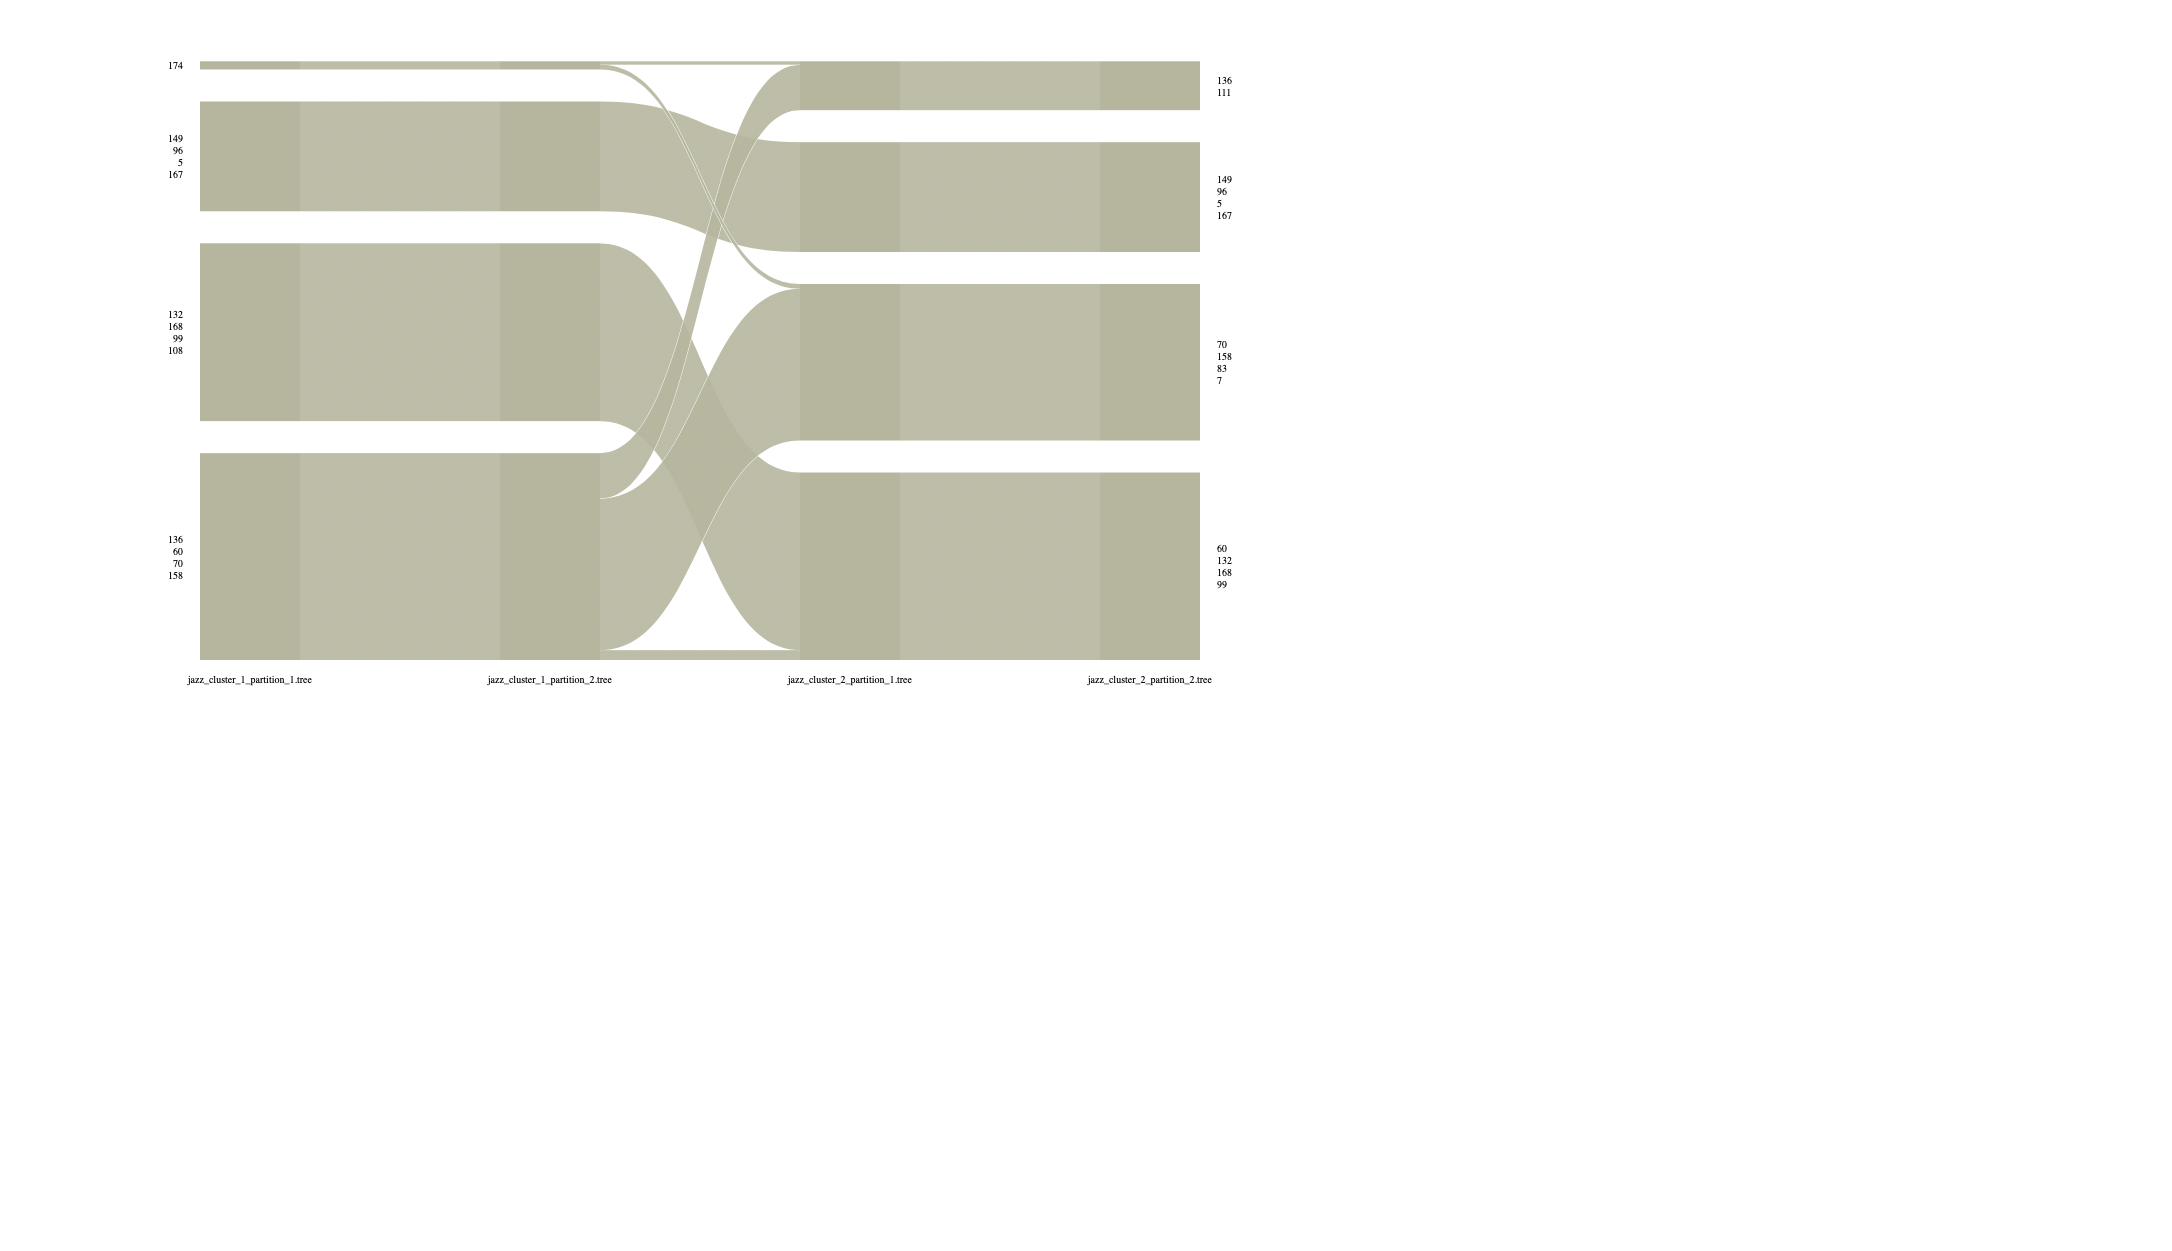

In [19]:
Image(filename='results/jazz_cluster_1_partition_1.tree,jazz_cluster_1_partition_2.tree,jazz_cluster_2_partition_1.tree,jazz_cluster_2_partition_2.tree.png')

**Figure 3** Close-by cluster centers are more similar than distant cluster centers. The alluvial diagram shows top two partitions in cluster 1 and 2.